In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import argparse
import pathlib
from tensorflow.keras import layers
import sys
import numpy as np
from sklearn.decomposition import IncrementalPCA
from scipy.stats import wasserstein_distance,energy_distance
from sklearn.decomposition import PCA
import os
import matplotlib.pyplot as plt

# Lista de Variables para Configuración

In [4]:
## Lista de Parametros
Arq = 'vgg16'
Cap = 'dense'
Att = 'CW'
Epx = '0005'
Epx_val = 0.005
DS = 'mnist'

In [5]:
def FGSM_GEN(model, image_in, target_label, epsilon,tiles=10):

  with tf.GradientTape() as tape:
    tape.watch(image_in)
    image= tf.expand_dims(image_in, axis=0)
    image = tf.tile(image, (tiles, 1, 1, 1))
    prediction = model(image)
    loss = tf.math.reduce_mean(nll(target_label, prediction))

  gradient = tape.gradient(loss, image_in)
  perturbation = epsilon * tf.sign(gradient)
  adversary = image_in + perturbation
  adversary = tf.clip_by_value(adversary, 0, 1)

  return adversary

## Ataque PGD
'''def pgd_attack(model, image, target_label, epsilon=0.15, num_steps=100, step_size=0.01):
    original_image = tf.identity(image)

    for _ in range(num_steps):
        with tf.GradientTape() as tape:
            tape.watch(image)
            logits = model(tf.expand_dims(image, axis=0))
            loss =- tf.keras.losses.CategoricalCrossentropy(from_logits=True)(tf.expand_dims(target_label, axis=0), logits)
            #loss = -tf.reduce_sum(target_label * tf.math.log(logits))

        gradient = tape.gradient(loss, image)
        perturbation = step_size * tf.sign(gradient)
        image = tf.clip_by_value(image + perturbation, original_image - epsilon, original_image + epsilon)
        image = tf.clip_by_value(image, 0.0, 1.0)
    return image'''

## Ataque C&W
def pgd_attack(model, image, target_label, num_steps=500, step_size=0.0, epsilon=0.01):
    def loss_(image,target_label):
        image = tf.expand_dims(image, axis=0)
        image_tile = tf.tile(image, (5, 1, 1, 1))
        logits = model(image_tile)
        targets = tf.reduce_sum(logits * target_label, axis=1)
        others = tf.reduce_max(logits * (1 - target_label), axis=1)
        return tf.maximum(0.0, others - targets + step_size)

    for _ in range(num_steps):
        with tf.GradientTape() as tape:
            tape.watch(image)
            loss = tf.math.reduce_mean(loss_(image,target_label))

        gradient = tape.gradient(loss, image)
        image = image - epsilon * tf.sign(gradient)
        image = tf.clip_by_value(image, 0., 255.)

    return image
def pgd_attack_soft(model, image, target_label, epsilon=0.15, num_steps=1000, step_size=0.001):
    original_image = tf.identity(image)

    for _ in range(num_steps):
        with tf.GradientTape() as tape:
            tape.watch(image)
            logits = model(tf.expand_dims(image, axis=0))
            loss =- tf.keras.losses.CategoricalCrossentropy()(tf.expand_dims(target_label, axis=0), logits)
            #loss = -tf.reduce_sum(target_label * tf.math.log(logits))

        gradient = tape.gradient(loss, image)
        perturbation = step_size * tf.sign(gradient)
        image = tf.clip_by_value(image + perturbation, original_image - epsilon, original_image + epsilon)
        image = tf.clip_by_value(image, 0.0, 1.0)

    return image
def get_layer_dictionary(model_pret,input_shape=(32,32,1)):
  dict_models={}
  input=xvar=tf.keras.Input(input_shape)
  for idx,layer in enumerate(model_pret.layers):
    xvar=layer(xvar)
    dict_models[layer.name]=tf.keras.Model(input,xvar,name=layer.name)
    print(idx,layer.name)
  return dict_models

In [6]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

## Ejemplo solo con la clase 0 para los de test-train

In [7]:
from models.vgg_b1_MNF_GUM import VGG as VGGb1
from models.vgg_bt_MNF_GUM import VGG as VGGbt
vgg_full_mnist=VGGb1(Arq,10)
vgg_1c_mnist=VGGbt(Arq,10)

vgg_full_mnist.build((None,32,32,1))
vgg_full_mnist.load_weights('/content/drive/MyDrive/Maestria/Trabajo de Grado/Git/Ejem_Adversarios_UElBosque/Modelos_Final/folder_models_vgg/vgg16MNFLUbt_GUM/mnist/checkpoint')
vgg_1c_mnist.build((None,32,32,1))
vgg_1c_mnist.load_weights('/content/drive/MyDrive/Maestria/Trabajo de Grado/Git/Ejem_Adversarios_UElBosque/Modelos_Final/folder_models_vgg/vgg16MNFLUb1_GUM/mnist/checkpoint')

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [8]:
def nll(y_true, y_pred):
    cross_entropy=-y_pred.log_prob(y_true)
    nll = tf.reduce_mean(cross_entropy)+vgg_full_mnist.kl_div() / len_train
    return nll
vgg_full_mnist.compile(optimizer="adam",
                loss=nll,
                metrics=["accuracy"])
vgg_1c_mnist.compile(optimizer="adam",
                loss=nll,
                metrics=["accuracy"])

# Verificar que los tres modelos estan correctamente cargados

# Victima 0

## Ataque 1

In [9]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = 0
Vic_loc = 5
Cat = 1

In [10]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [11]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [12]:
vgg_full_mnist.evaluate(train_ds_tf)

15/15 [==============================] - 36s 559ms/step - loss: 1288253828984400248832.0000 - accuracy: 0.9948


[1.2882538289844002e+21, 0.9947916865348816]

In [13]:
vgg_1c_mnist.evaluate(train_ds_tf)

15/15 [==============================] - 20s 227ms/step - loss: 50379747338747904.0000 - accuracy: 0.9885


[5.03797473387479e+16, 0.9885416626930237]

### 100 Bayesiano

In [14]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [15]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [16]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [17]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [18]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [19]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  0


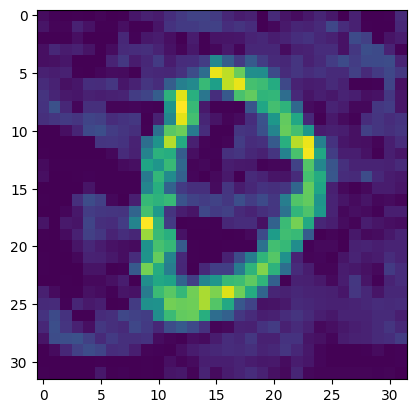

In [20]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [21]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [22]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [23]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [24]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.7468803355172601
distancia energia distribucion base y el ejemplo natural  0.48777396170978937


In [25]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [26]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.2738138028269113
distancia energia distribucion base y el ejemplo adversario  1.5410818001378357


In [27]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-28-b23951ae16f6>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-28-b23951ae16f6>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

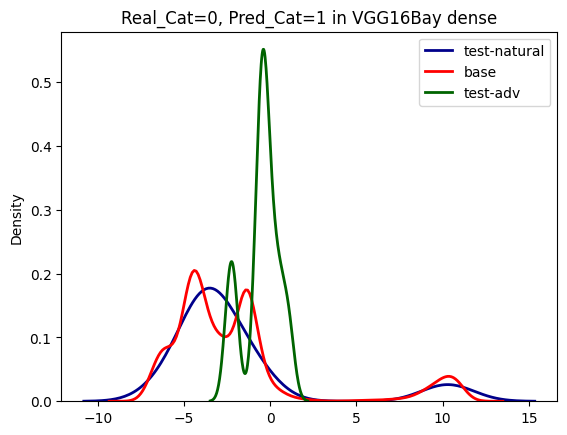

In [28]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'B1GUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [29]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [30]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [31]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [32]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [33]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  0


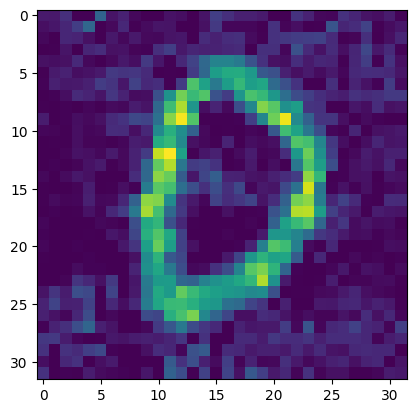

In [34]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [35]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [36]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [37]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

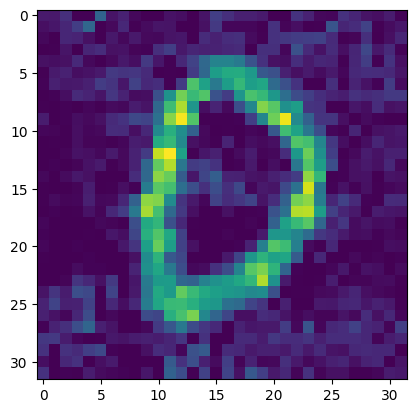

In [38]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [39]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.3193951007574079
distancia energia distribucion base y el ejemplo natural  0.29658521135708954


In [40]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [41]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.984410961603962
distancia energia distribucion base y el ejemplo adversario  1.6361436684858806


In [42]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-43-08a31cdca667>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-43-08a31cdca667>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

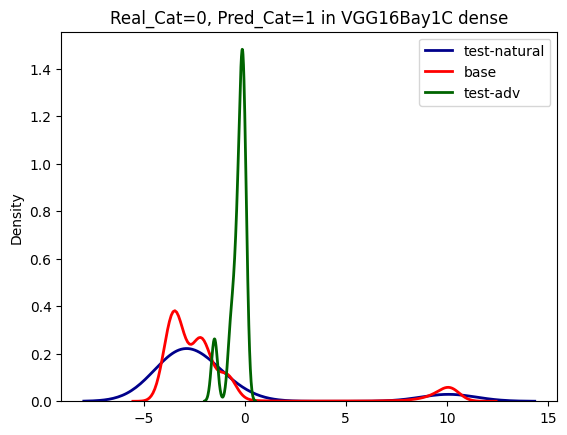

In [43]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'1CGUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 2

In [44]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 2

In [45]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [46]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [47]:
vgg_full_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 4s 264ms/step - loss: 228833983963066269696.0000 - accuracy: 0.9933


[2.2883398396306627e+20, 0.9933035969734192]

In [48]:
vgg_1c_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 2s 105ms/step - loss: 903784745417048064.0000 - accuracy: 0.9877


[9.03784745417048e+17, 0.9877232313156128]

### 100 Bayesiano

In [49]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [50]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [51]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [52]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [53]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [54]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  0


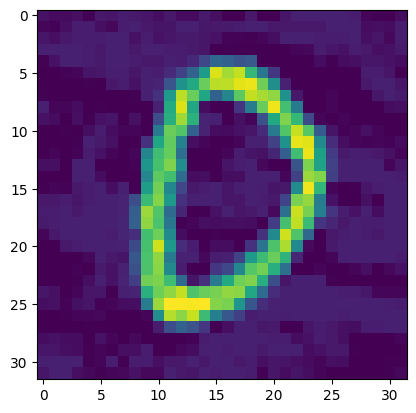

In [55]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [56]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


In [57]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [58]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [59]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.9713223049596812
distancia energia distribucion base y el ejemplo natural  0.5602600882331089


In [60]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [61]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  1.6176294531047792
distancia energia distribucion base y el ejemplo adversario  0.6429043628530521


In [62]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-63-b23951ae16f6>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-63-b23951ae16f6>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

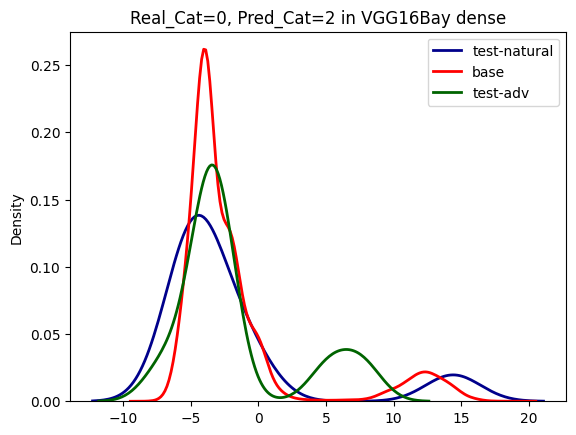

In [63]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'B1GUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [64]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [65]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [66]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [67]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [68]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  0


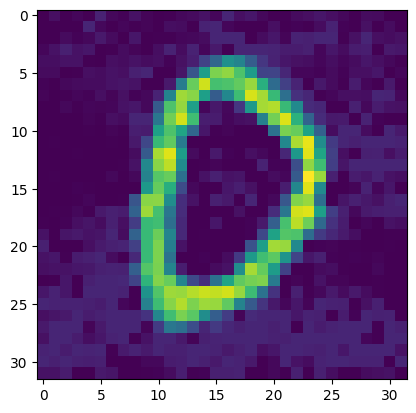

In [69]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [70]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


In [71]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [72]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

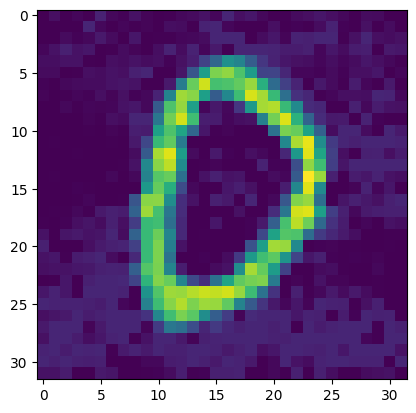

In [73]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [74]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.086299048242983
distancia energia distribucion base y el ejemplo natural  0.5661870945220938


In [75]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [76]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.510567486614617
distancia energia distribucion base y el ejemplo adversario  1.0551729965587844


In [77]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-78-08a31cdca667>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-78-08a31cdca667>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

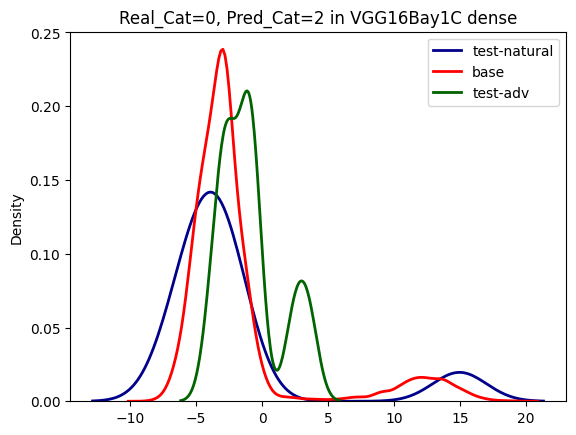

In [78]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'1CGUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 3

In [79]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 3

In [80]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [81]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [82]:
vgg_full_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 5s 301ms/step - loss: 2587077742633680896.0000 - accuracy: 0.9855


[2.587077742633681e+18, 0.9854910969734192]

In [83]:
vgg_1c_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 2s 106ms/step - loss: 3998703887895756800.0000 - accuracy: 0.9989


[3.998703887895757e+18, 0.9988839030265808]

### 100 Bayesiano

In [84]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [85]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [86]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [87]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [88]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [89]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

el label verdadero es:  0


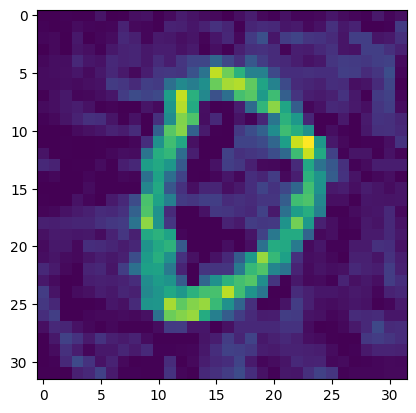

In [90]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [91]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


In [92]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [93]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [94]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.5319010071570199
distancia energia distribucion base y el ejemplo natural  0.3339555922653784


In [95]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [96]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.4261017156163236
distancia energia distribucion base y el ejemplo adversario  1.0257945419696226


In [97]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-98-b23951ae16f6>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-98-b23951ae16f6>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

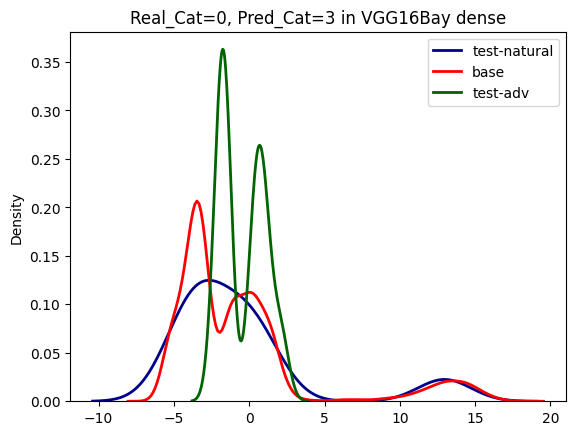

In [98]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'B1GUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [99]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [100]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [101]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [102]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [103]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  0


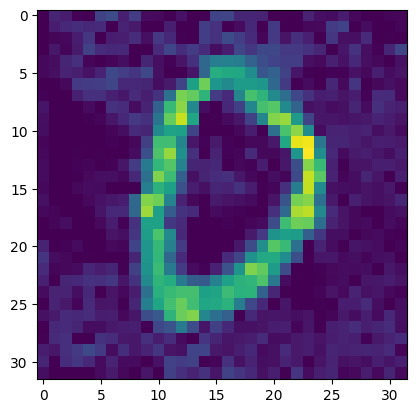

In [104]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [105]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


In [106]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [107]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

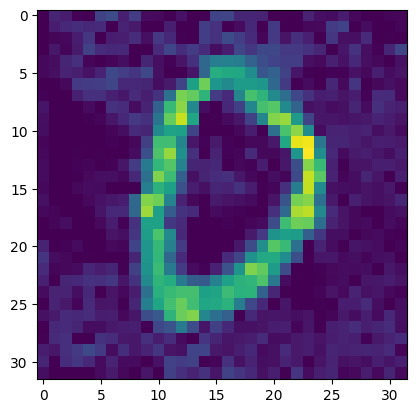

In [108]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [109]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.8804366541231645
distancia energia distribucion base y el ejemplo natural  0.4713529332795841


In [110]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [111]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.007061330964696
distancia energia distribucion base y el ejemplo adversario  1.5897665952758495


In [112]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-113-08a31cdca667>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-113-08a31cdca667>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

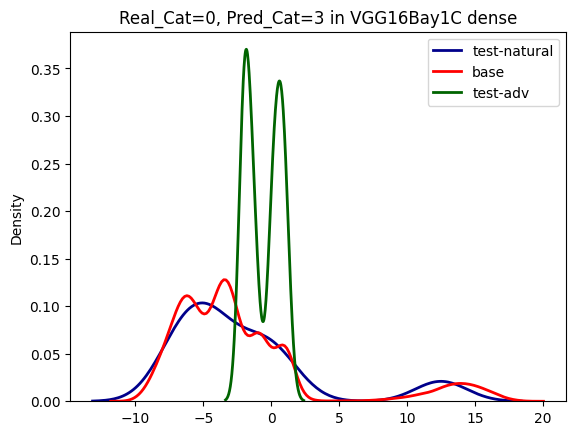

In [113]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'1CGUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 4

In [114]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 4

In [115]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [116]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [117]:
vgg_full_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 4s 259ms/step - loss: 7749213916542009344.0000 - accuracy: 0.9976


[7.749213916542009e+18, 0.9975961446762085]

In [118]:
vgg_1c_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 2s 117ms/step - loss: 350930095445114880.0000 - accuracy: 0.9856


[3.509300954451149e+17, 0.9855769276618958]

### 100 Bayesiano

In [119]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [120]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [121]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [122]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [123]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [124]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

el label verdadero es:  0


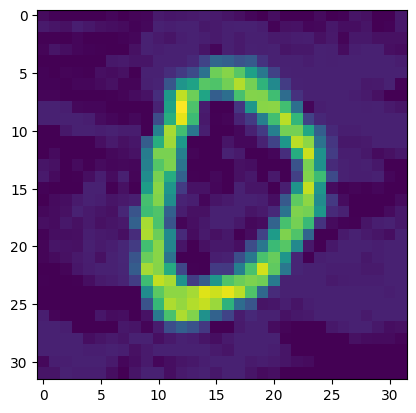

In [125]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [126]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


In [127]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [128]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [129]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.4516712722388914
distancia energia distribucion base y el ejemplo natural  0.6807679470187917


In [130]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [131]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.3131780994150875
distancia energia distribucion base y el ejemplo adversario  1.185893042873527


In [132]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-133-b23951ae16f6>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-133-b23951ae16f6>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

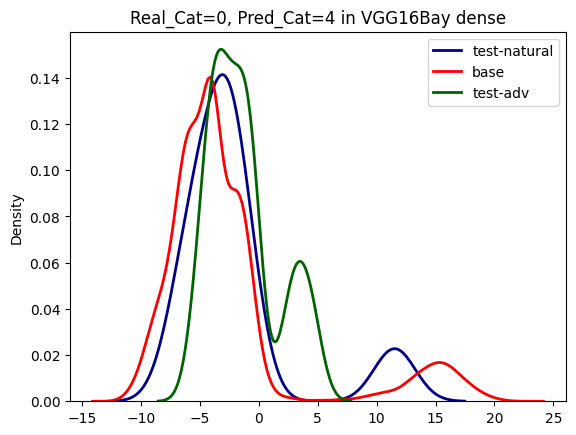

In [133]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'B1GUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [134]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [135]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [136]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [137]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [138]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  0


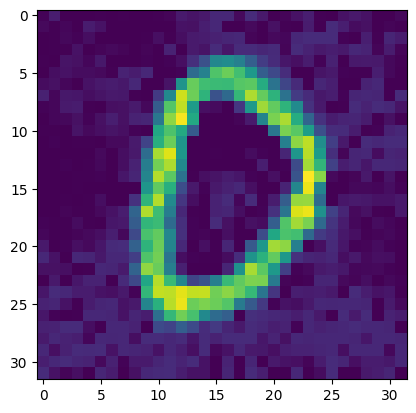

In [139]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [140]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


In [141]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [142]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

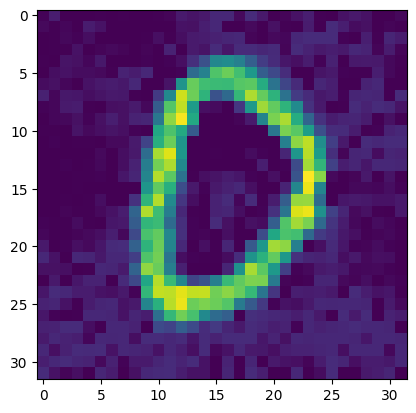

In [143]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [144]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.6955781469224411
distancia energia distribucion base y el ejemplo natural  0.4213587935957211


In [145]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [146]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.7048194413503945
distancia energia distribucion base y el ejemplo adversario  1.0786040346767323


In [147]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-148-08a31cdca667>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-148-08a31cdca667>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

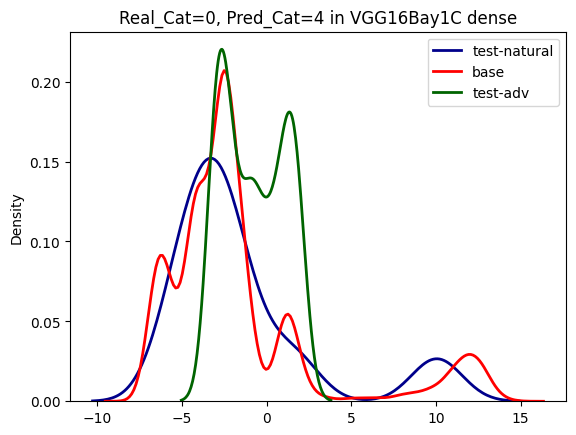

In [148]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'1CGUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 5

In [149]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 5

In [150]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [151]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [152]:
vgg_full_mnist.evaluate(train_ds_tf)

12/12 [==============================] - 3s 270ms/step - loss: 87229591780851712.0000 - accuracy: 0.9948


[8.722959178085171e+16, 0.9947916865348816]

In [153]:
vgg_1c_mnist.evaluate(train_ds_tf)

12/12 [==============================] - 1s 106ms/step - loss: 6008302730458693632.0000 - accuracy: 0.9909


[6.008302730458694e+18, 0.9908854365348816]

### 100 Bayesiano

In [154]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [155]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [156]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [157]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [158]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [159]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

el label verdadero es:  0


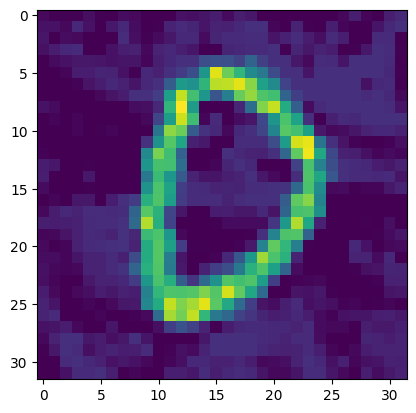

In [160]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [161]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]


In [162]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [163]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [164]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.7634034704504176
distancia energia distribucion base y el ejemplo natural  0.42241830689206816


In [165]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [166]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.6362678692278365
distancia energia distribucion base y el ejemplo adversario  1.3224472313061493


In [167]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-168-b23951ae16f6>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-168-b23951ae16f6>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

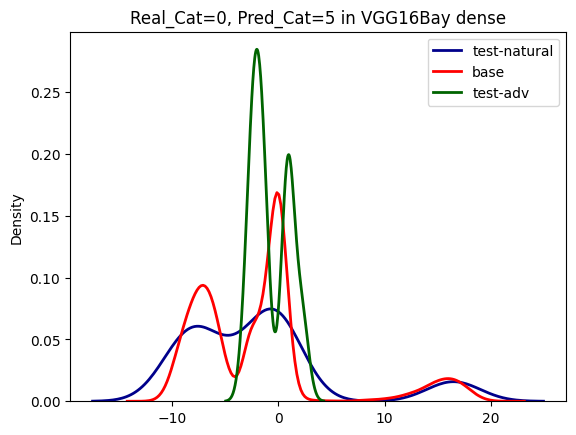

In [168]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'B1GUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [169]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [170]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [171]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [172]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [173]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  0


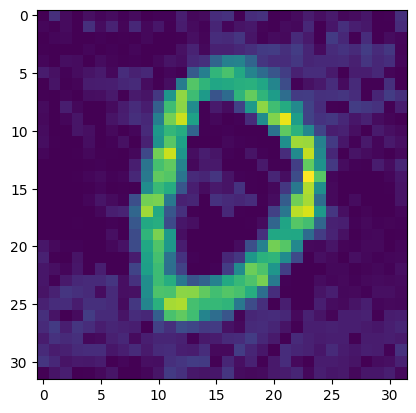

In [174]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [175]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]


In [176]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [177]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

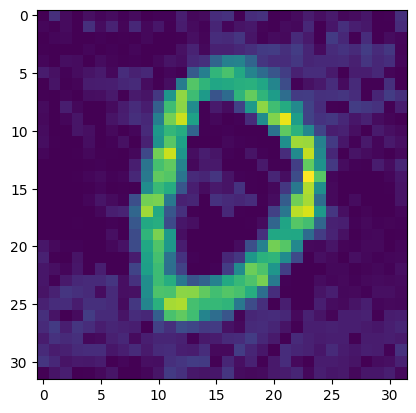

In [178]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [179]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.6450372215780301
distancia energia distribucion base y el ejemplo natural  0.41620226733355586


In [180]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [181]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.292649981316351
distancia energia distribucion base y el ejemplo adversario  1.4131593635488304


In [182]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-183-08a31cdca667>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-183-08a31cdca667>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

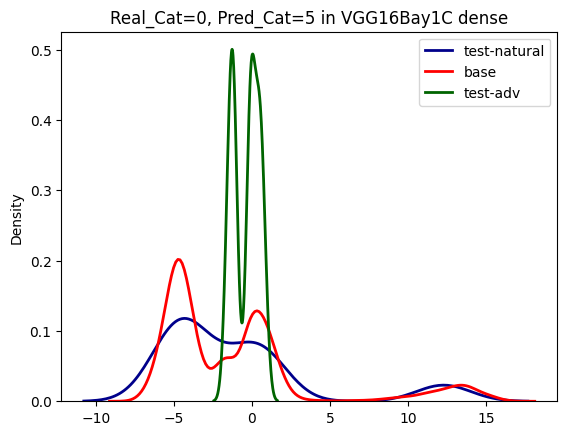

In [183]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'1CGUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 6

In [184]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 6

In [185]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [186]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [187]:
vgg_full_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 5s 346ms/step - loss: 9775527028064256.0000 - accuracy: 0.9868


[9775527028064256.0, 0.9867788553237915]

In [188]:
vgg_1c_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 2s 153ms/step - loss: 44037165430348594544640.0000 - accuracy: 0.9928


[4.4037165430348595e+22, 0.9927884340286255]

### 100 Bayesiano

In [189]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [190]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [191]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [192]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [193]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [194]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

el label verdadero es:  0


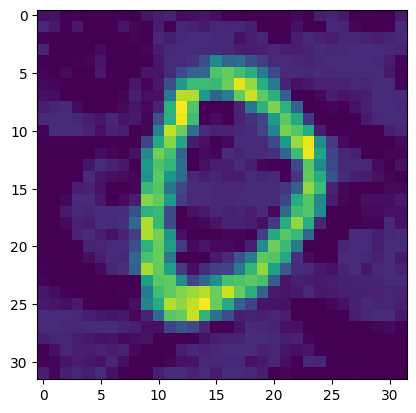

In [195]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [196]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]


In [197]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [198]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [199]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.1089847637912664
distancia energia distribucion base y el ejemplo natural  0.5148950373366222


In [200]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [201]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.40135719252904
distancia energia distribucion base y el ejemplo adversario  1.511774286561082


In [202]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-203-b23951ae16f6>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-203-b23951ae16f6>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

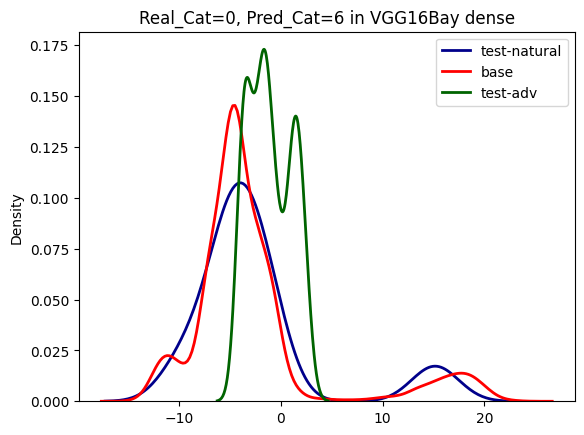

In [203]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'B1GUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [204]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [205]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [206]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [207]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [208]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  0


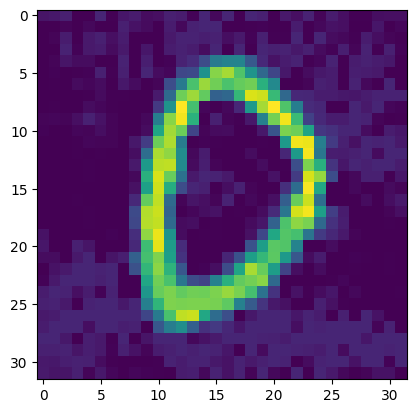

In [209]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [210]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]


In [211]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [212]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

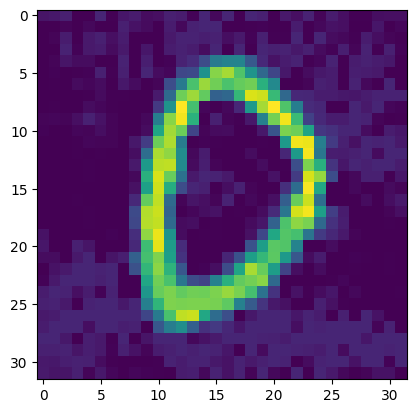

In [213]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [214]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.9906122522175824
distancia energia distribucion base y el ejemplo natural  0.5088127949602158


In [215]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [216]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.16101814259864
distancia energia distribucion base y el ejemplo adversario  0.7143753653896949


In [217]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-218-08a31cdca667>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-218-08a31cdca667>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

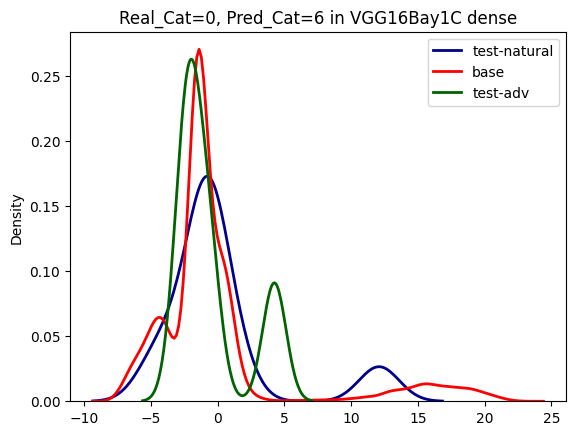

In [218]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'1CGUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 7

In [219]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 7

In [220]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [221]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [222]:
vgg_full_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 4s 259ms/step - loss: 239697847002333184.0000 - accuracy: 0.9877


[2.396978470023332e+17, 0.9877232313156128]

In [223]:
vgg_1c_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 3s 176ms/step - loss: 1062318104345837568.0000 - accuracy: 0.9821


[1.0623181043458376e+18, 0.9821428656578064]

### 100 Bayesiano

In [224]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [225]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [226]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [227]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [228]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [229]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

el label verdadero es:  0


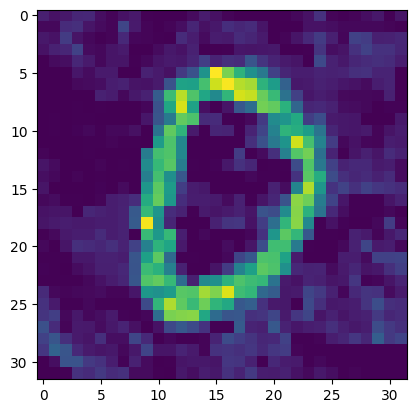

In [230]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [231]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]


In [232]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [233]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [234]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.485925005623419
distancia energia distribucion base y el ejemplo natural  0.5928334884540798


In [235]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [236]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.7627661986683307
distancia energia distribucion base y el ejemplo adversario  0.9795487577404802


In [237]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-238-b23951ae16f6>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-238-b23951ae16f6>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

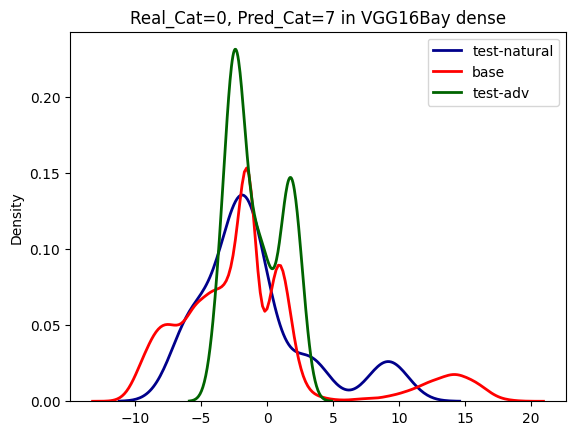

In [238]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'B1GUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [239]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [240]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [241]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [242]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [243]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  0


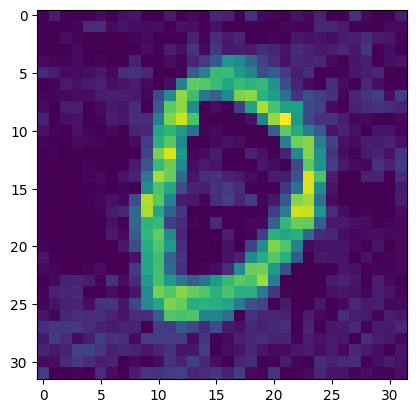

In [244]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [245]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]


In [246]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [247]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

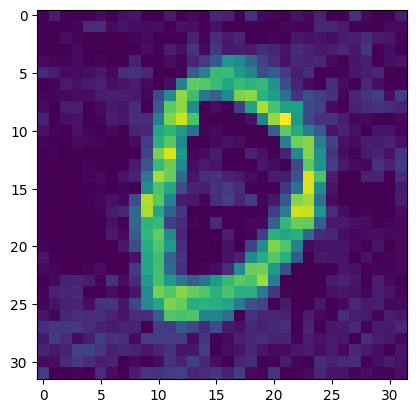

In [248]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [249]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.7127328550419636
distancia energia distribucion base y el ejemplo natural  0.7777966196671454


In [250]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [251]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.2708627384052287
distancia energia distribucion base y el ejemplo adversario  1.3404093050852994


In [252]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-253-08a31cdca667>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-253-08a31cdca667>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

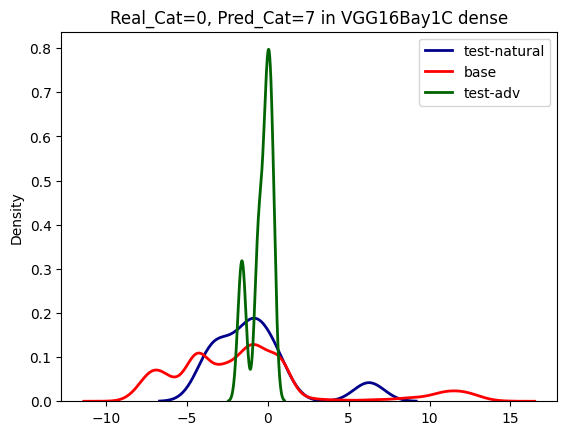

In [253]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'1CGUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 8

In [254]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 8

In [255]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [256]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [257]:
vgg_full_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 4s 265ms/step - loss: 5524116842248929280.0000 - accuracy: 0.9868


[5.524116842248929e+18, 0.9867788553237915]

In [258]:
vgg_1c_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 1s 104ms/step - loss: 5311050730239426560.0000 - accuracy: 0.9880


[5.311050730239427e+18, 0.9879807829856873]

### 100 Bayesiano

In [259]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [260]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [261]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [262]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [263]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [264]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

el label verdadero es:  0


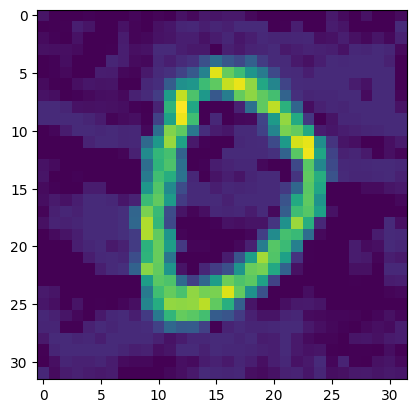

In [265]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [266]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [267]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [268]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [269]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.9591792438004637
distancia energia distribucion base y el ejemplo natural  0.6194601613204948


In [270]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [271]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.501074496807561
distancia energia distribucion base y el ejemplo adversario  1.066866745842526


In [272]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-273-b23951ae16f6>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-273-b23951ae16f6>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

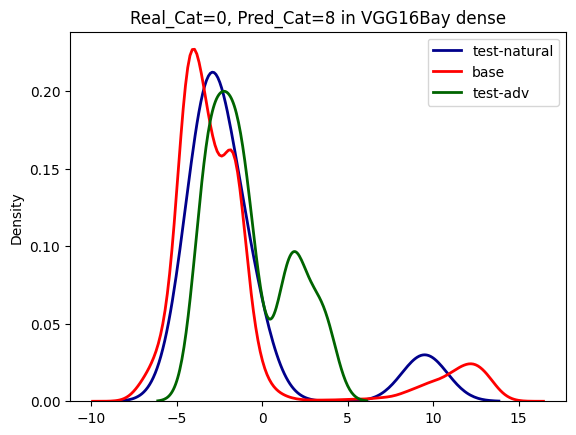

In [273]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'B1GUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [274]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [275]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [276]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [277]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [278]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  0


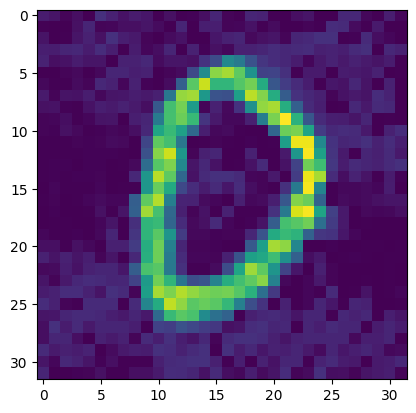

In [279]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [280]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [281]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [282]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

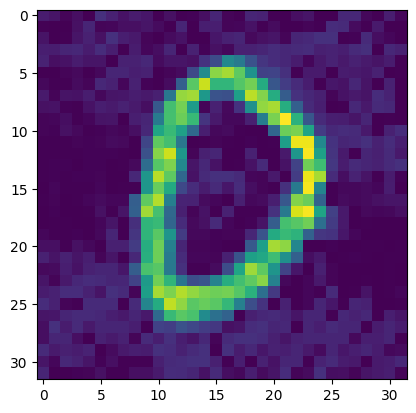

In [283]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [284]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.8069149950942788
distancia energia distribucion base y el ejemplo natural  0.46875260489484466


In [285]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [286]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.6928758694444883
distancia energia distribucion base y el ejemplo adversario  1.149071919182906


In [287]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-288-08a31cdca667>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-288-08a31cdca667>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

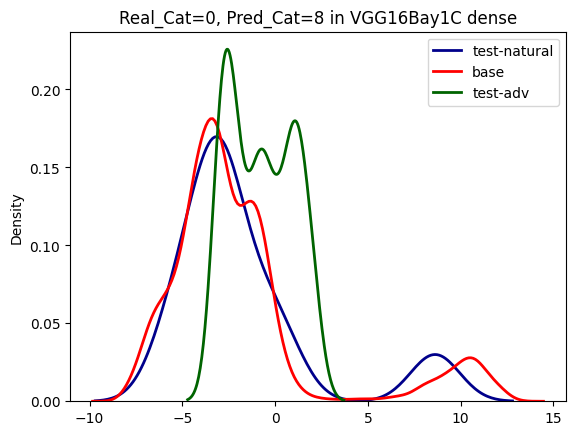

In [288]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'1CGUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 9

In [289]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 9

In [290]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [291]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [292]:
vgg_full_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 5s 378ms/step - loss: 167438131803455488.0000 - accuracy: 0.9710


[1.674381318034555e+17, 0.9709821343421936]

In [293]:
vgg_1c_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 1s 103ms/step - loss: 32177613661274112.0000 - accuracy: 0.9855


[3.217761366127411e+16, 0.9854910969734192]

### 100 Bayesiano

In [294]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [295]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [296]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [297]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [298]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [299]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

el label verdadero es:  0


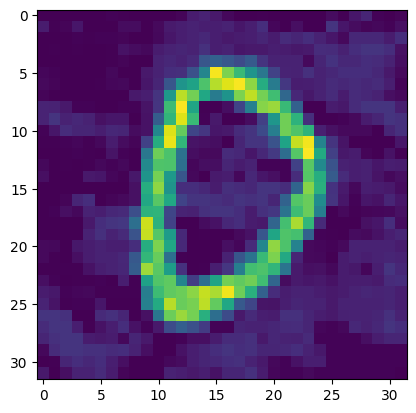

In [300]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [301]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]


In [302]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [303]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [304]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.241481592455931
distancia energia distribucion base y el ejemplo natural  0.579369076178575


In [305]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [306]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.300574947318774
distancia energia distribucion base y el ejemplo adversario  1.286480073934629


In [307]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-308-b23951ae16f6>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-308-b23951ae16f6>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

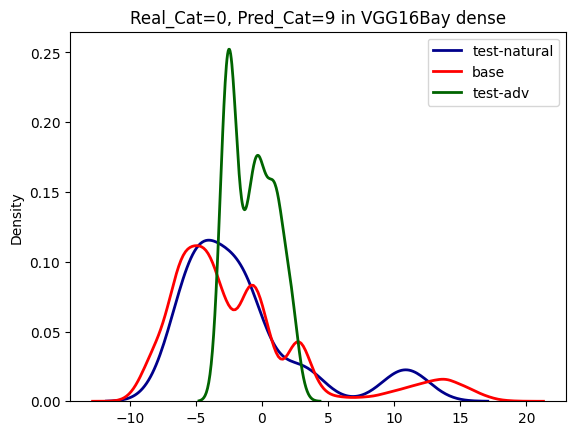

In [308]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'B1GUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [309]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [310]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [311]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [312]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [313]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  0


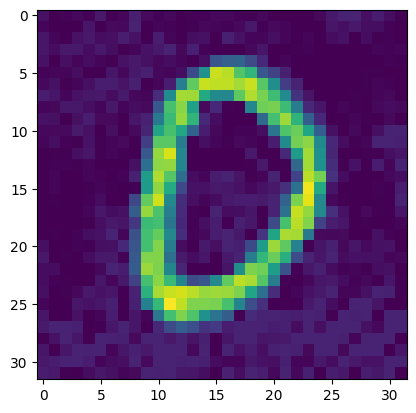

In [314]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [315]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]


In [316]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [317]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

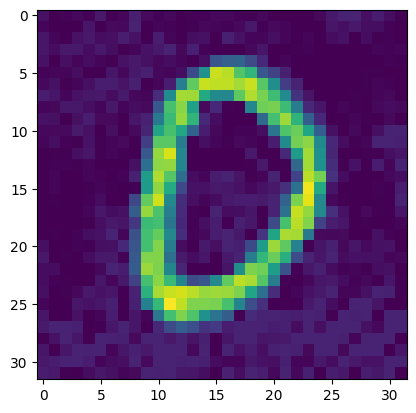

In [318]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [319]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.2291440679218153
distancia energia distribucion base y el ejemplo natural  0.5870078449640871


In [320]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [321]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.702931142302968
distancia energia distribucion base y el ejemplo adversario  0.9949881278922216


In [322]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-323-08a31cdca667>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-323-08a31cdca667>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

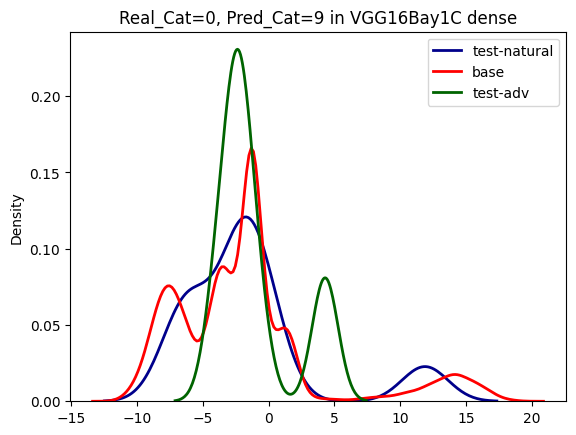

In [323]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'1CGUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

# Victima 1

## Ataque 0

In [324]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = 1
Vic_loc = 1
Cat = 0

In [325]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [326]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [327]:
vgg_full_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 5s 392ms/step - loss: 2967192106495377408.0000 - accuracy: 0.9928


[2.9671921064953774e+18, 0.9927884340286255]

In [328]:
vgg_1c_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 1s 104ms/step - loss: 12885370039435264.0000 - accuracy: 0.9976


[1.2885370039435264e+16, 0.9975961446762085]

### 100 Bayesiano

In [329]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [330]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [331]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [332]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [333]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [334]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  1


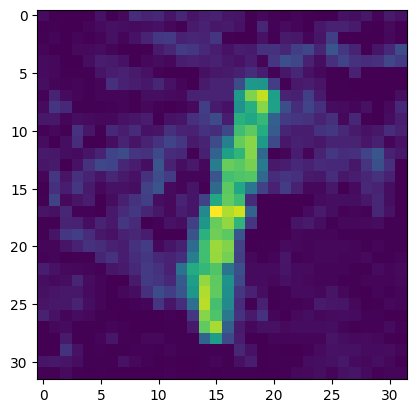

In [335]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [336]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [337]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [338]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [339]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.1816136613659425
distancia energia distribucion base y el ejemplo natural  0.5606182264593191


In [340]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [341]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.377204947224083
distancia energia distribucion base y el ejemplo adversario  1.5445366051731653


In [342]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-343-b23951ae16f6>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-343-b23951ae16f6>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

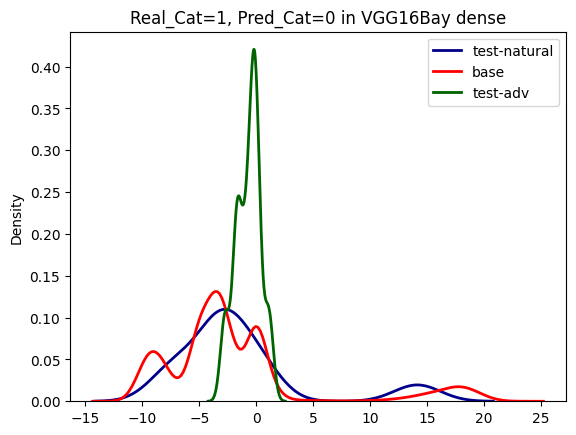

In [343]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'B1GUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [344]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [345]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [346]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [347]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [348]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  1


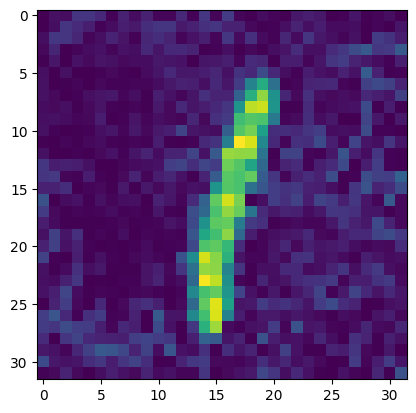

In [349]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [350]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [351]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [352]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

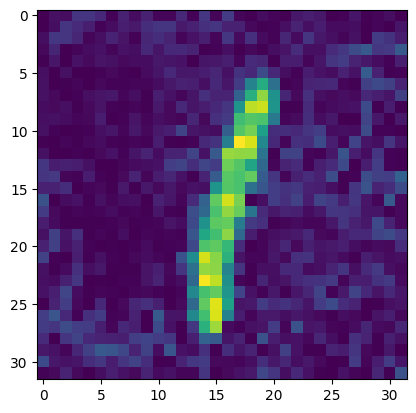

In [353]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [354]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.721691415640859
distancia energia distribucion base y el ejemplo natural  0.4783235046082613


In [355]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [356]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.171208042368156
distancia energia distribucion base y el ejemplo adversario  1.825406045082147


In [357]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-358-08a31cdca667>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-358-08a31cdca667>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

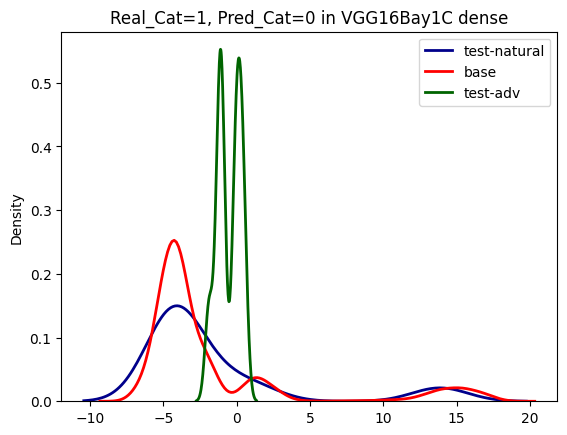

In [358]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'1CGUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 2

In [359]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 2

In [360]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [361]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [362]:
vgg_full_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 5s 379ms/step - loss: 25679798441345024.0000 - accuracy: 0.9944


[2.5679798441345024e+16, 0.9944196343421936]

In [363]:
vgg_1c_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 1s 103ms/step - loss: 28067255312470507520.0000 - accuracy: 0.9888


[2.8067255312470508e+19, 0.9888392686843872]

### 100 Bayesiano

In [364]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [365]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [366]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [367]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [368]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [369]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  1


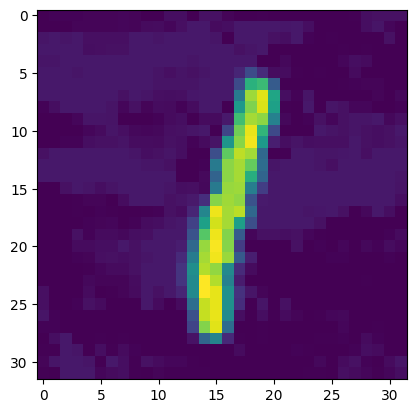

In [370]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [371]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


In [372]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [373]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [374]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.9222924540836848
distancia energia distribucion base y el ejemplo natural  0.5399407471274318


In [375]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [376]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.4051994893150597
distancia energia distribucion base y el ejemplo adversario  0.9792973678922442


In [377]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-378-b23951ae16f6>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-378-b23951ae16f6>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

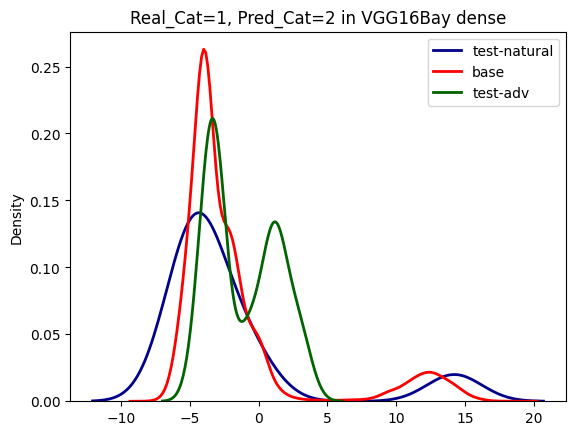

In [378]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'B1GUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [379]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [380]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [381]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [382]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [383]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  1


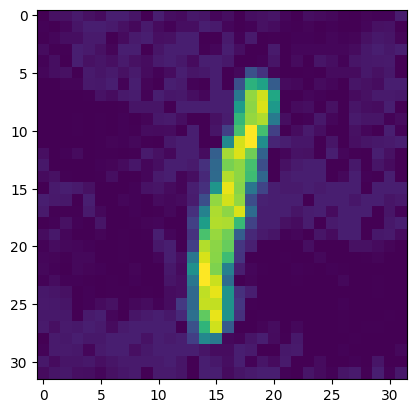

In [384]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [385]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


In [386]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [387]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

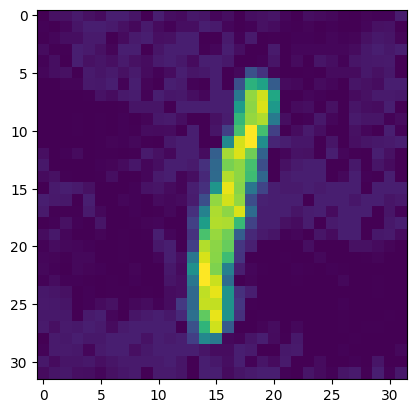

In [388]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [389]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.0910509239175232
distancia energia distribucion base y el ejemplo natural  0.5675416110938746


In [390]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [391]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.1560959679798875
distancia energia distribucion base y el ejemplo adversario  1.3796610322124365


In [392]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-393-08a31cdca667>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-393-08a31cdca667>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

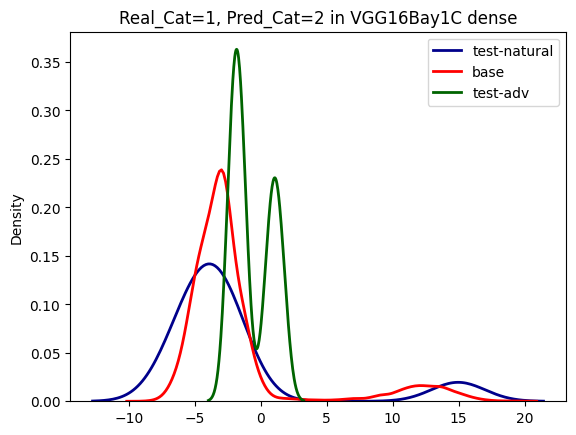

In [393]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'1CGUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 3

In [394]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 3

In [395]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [396]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [397]:
vgg_full_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 4s 258ms/step - loss: 1296772397575176192.0000 - accuracy: 0.9855


[1.2967723975751762e+18, 0.9854910969734192]

In [398]:
vgg_1c_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 2s 103ms/step - loss: 24200815715549184.0000 - accuracy: 0.9989


[2.4200815715549184e+16, 0.9988839030265808]

### 100 Bayesiano

In [399]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [400]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [401]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [402]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [403]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [404]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

el label verdadero es:  1


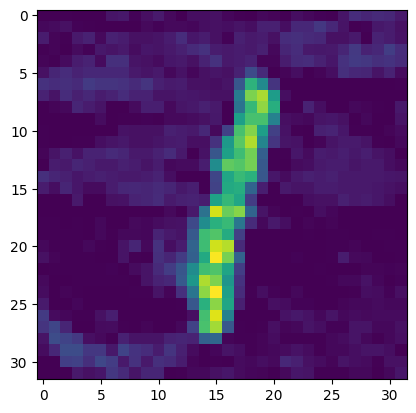

In [405]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [406]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


In [407]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [408]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [409]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.5350055948977966
distancia energia distribucion base y el ejemplo natural  0.33526910062517623


In [410]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [411]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.0704663130704155
distancia energia distribucion base y el ejemplo adversario  0.7837864513252779


In [412]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-413-b23951ae16f6>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-413-b23951ae16f6>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

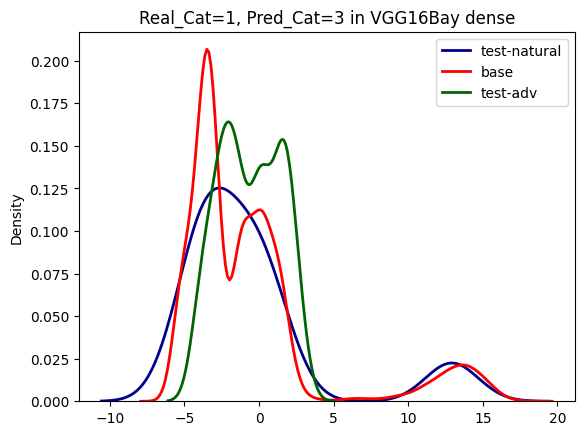

In [413]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'B1GUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [414]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [415]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [416]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [417]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [418]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  1


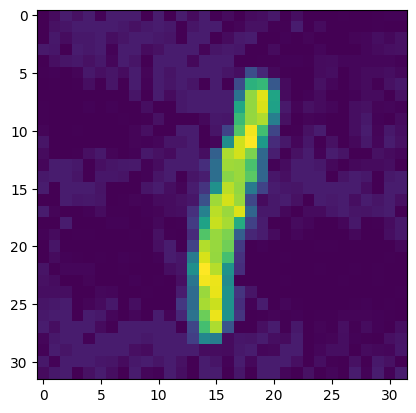

In [419]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [420]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


In [421]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [422]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

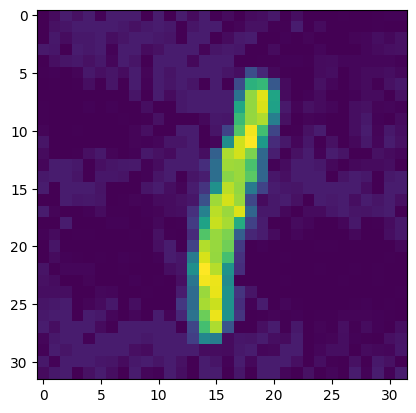

In [423]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [424]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.8791447953451654
distancia energia distribucion base y el ejemplo natural  0.471080092914138


In [425]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [426]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.5538947797637555
distancia energia distribucion base y el ejemplo adversario  1.4704362608156842


In [427]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-428-08a31cdca667>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-428-08a31cdca667>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

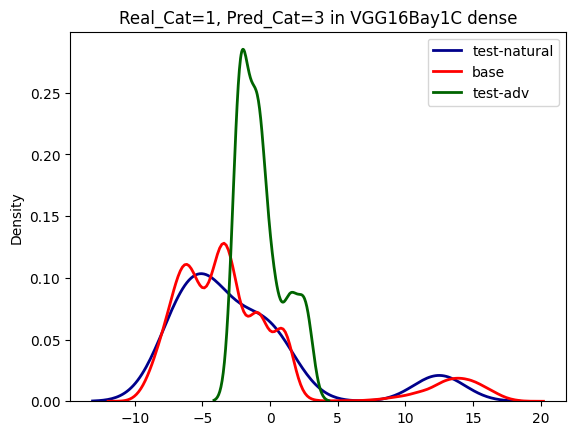

In [428]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'1CGUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 4

In [429]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 4

In [430]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [431]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [432]:
vgg_full_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 4s 301ms/step - loss: 481484023102458298368.0000 - accuracy: 0.9988


[4.814840231024583e+20, 0.9987980723381042]

In [433]:
vgg_1c_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 1s 107ms/step - loss: 46951641882034176.0000 - accuracy: 0.9832


[4.695164188203418e+16, 0.9831730723381042]

### 100 Bayesiano

In [434]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [435]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [436]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [437]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [438]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [439]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

el label verdadero es:  1


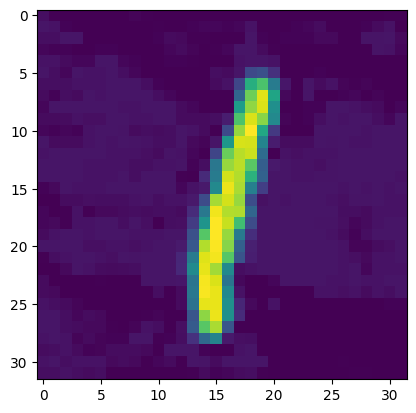

In [440]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [441]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


In [442]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [443]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [444]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.5043637233669942
distancia energia distribucion base y el ejemplo natural  0.7015586992936765


In [445]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [446]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.173627925245275
distancia energia distribucion base y el ejemplo adversario  0.7530447652172374


In [447]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-448-b23951ae16f6>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-448-b23951ae16f6>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

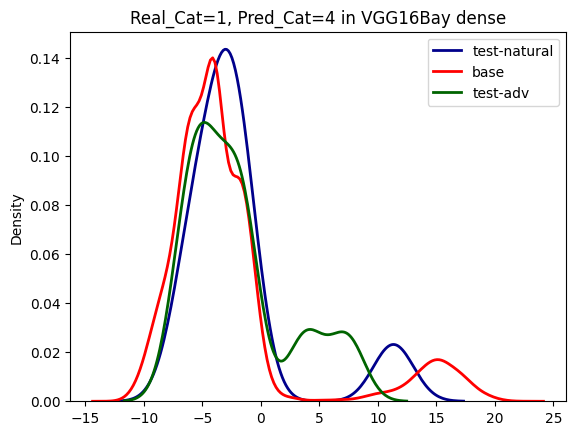

In [448]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'B1GUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [449]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [450]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [451]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [452]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [453]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  1


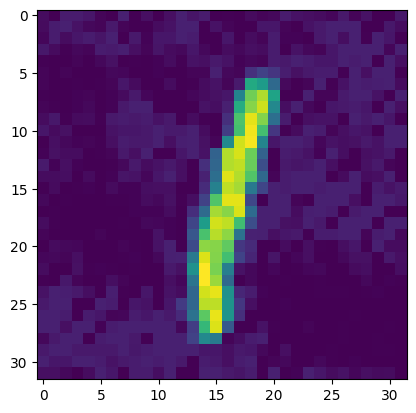

In [454]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [455]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


In [456]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [457]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

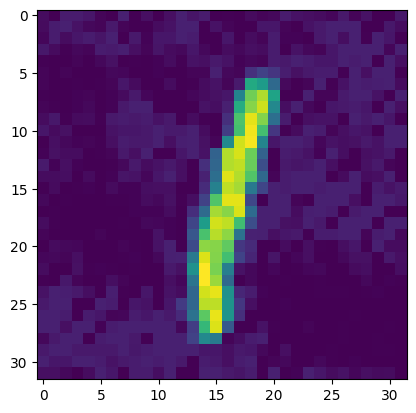

In [458]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [459]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.7043449286844361
distancia energia distribucion base y el ejemplo natural  0.4246120616366108


In [460]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [461]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.688332499214795
distancia energia distribucion base y el ejemplo adversario  1.145271660188231


In [462]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-463-08a31cdca667>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-463-08a31cdca667>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

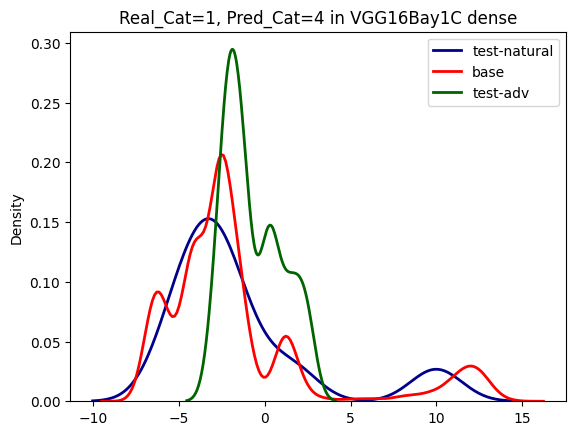

In [463]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'1CGUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 5

In [464]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 5

In [465]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [466]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [467]:
vgg_full_mnist.evaluate(train_ds_tf)

12/12 [==============================] - 5s 389ms/step - loss: 3707037546703338078208.0000 - accuracy: 0.9948


[3.707037546703338e+21, 0.9947916865348816]

In [468]:
vgg_1c_mnist.evaluate(train_ds_tf)

12/12 [==============================] - 1s 107ms/step - loss: 1572161302548185088.0000 - accuracy: 0.9896


[1.572161302548185e+18, 0.9895833134651184]

### 100 Bayesiano

In [469]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [470]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [471]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [472]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [473]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [474]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

el label verdadero es:  1


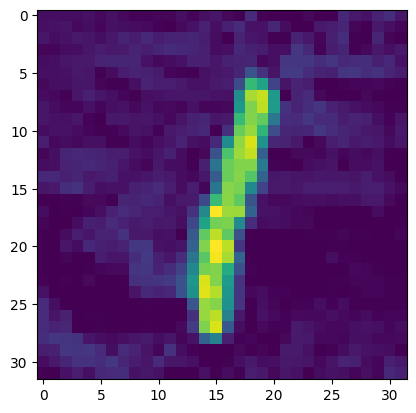

In [475]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [476]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]


In [477]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [478]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [479]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.7884615740344184
distancia energia distribucion base y el ejemplo natural  0.43188697007745525


In [480]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [481]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.776806000869253
distancia energia distribucion base y el ejemplo adversario  1.3965628007544963


In [482]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-483-b23951ae16f6>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-483-b23951ae16f6>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

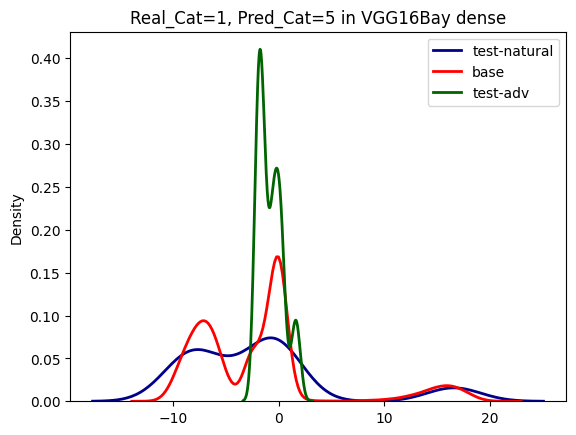

In [483]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'B1GUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [484]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [485]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [486]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [487]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [488]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  1


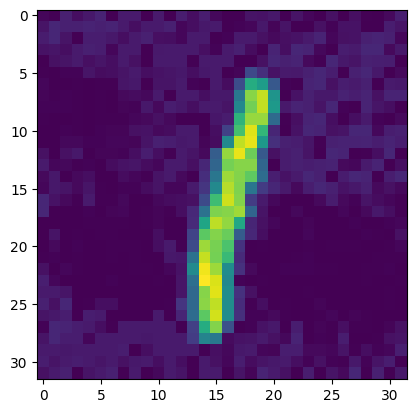

In [489]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [490]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]


In [491]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [492]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

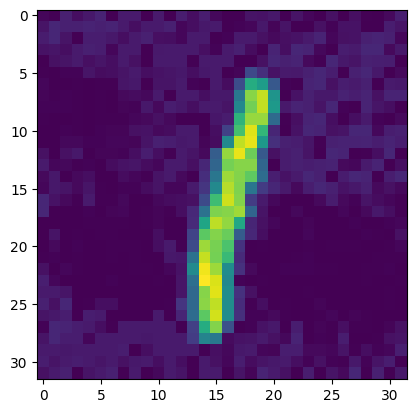

In [493]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [494]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.6438026030930287
distancia energia distribucion base y el ejemplo natural  0.41539604675991826


In [495]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [496]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.9728626186230294
distancia energia distribucion base y el ejemplo adversario  1.2812027492473022


In [497]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-498-08a31cdca667>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-498-08a31cdca667>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

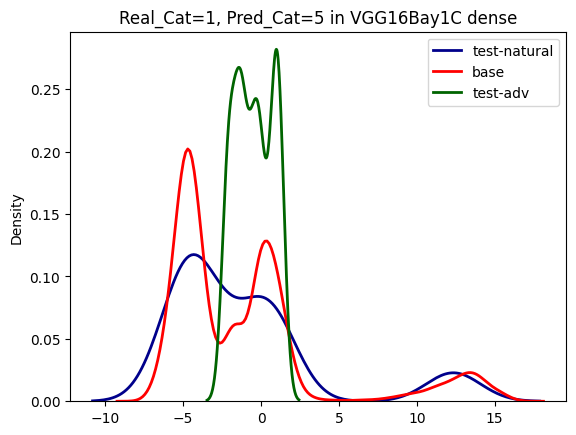

In [498]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'1CGUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 6

In [499]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 6

In [500]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [501]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [502]:
vgg_full_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 4s 261ms/step - loss: 199983229309026304.0000 - accuracy: 0.9868


[1.999832293090263e+17, 0.9867788553237915]

In [503]:
vgg_1c_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 1s 105ms/step - loss: 74896269178054901760.0000 - accuracy: 0.9916


[7.48962691780549e+19, 0.9915865659713745]

### 100 Bayesiano

In [504]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [505]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [506]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [507]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [508]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [509]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

el label verdadero es:  1


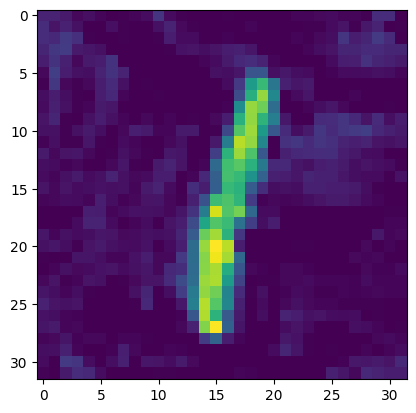

In [510]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [511]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]


In [512]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [513]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [514]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.1338166413713717
distancia energia distribucion base y el ejemplo natural  0.5225796300194736


In [515]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [516]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.349947060876092
distancia energia distribucion base y el ejemplo adversario  1.488580428372681


In [517]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-518-b23951ae16f6>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-518-b23951ae16f6>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

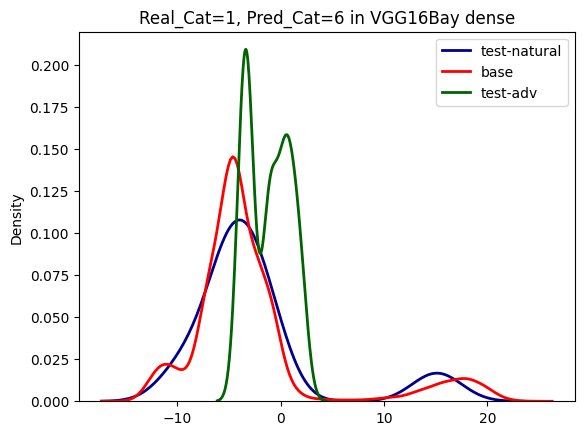

In [518]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'B1GUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [519]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [520]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [521]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [522]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [523]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  1


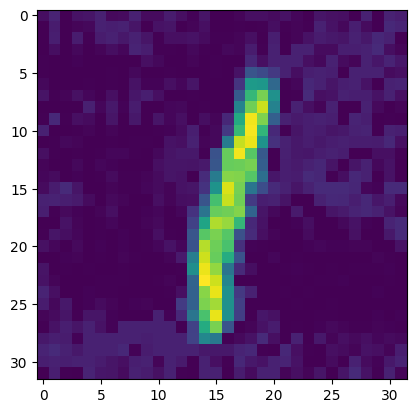

In [524]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [525]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]


In [526]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [527]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

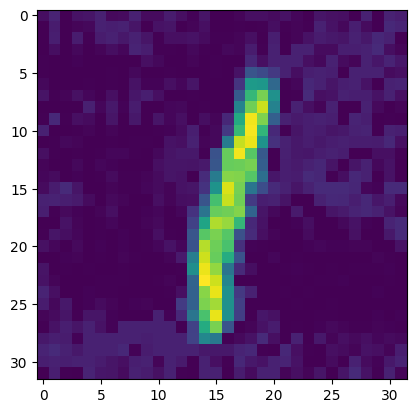

In [528]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [529]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.9841244312016947
distancia energia distribucion base y el ejemplo natural  0.5054753000849002


In [530]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [531]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.4541825398942723
distancia energia distribucion base y el ejemplo adversario  0.8217122348515373


In [532]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-533-08a31cdca667>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-533-08a31cdca667>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

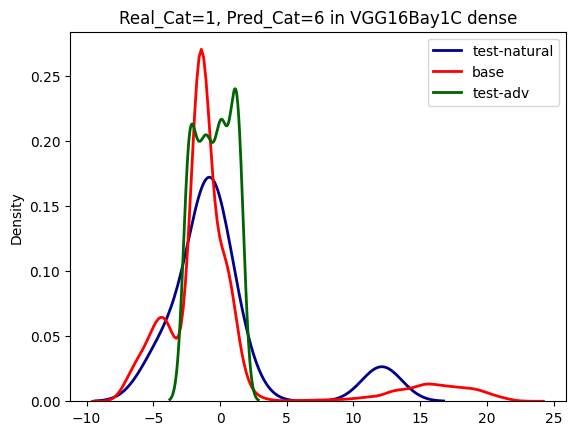

In [533]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'1CGUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 7

In [534]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 7

In [535]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [536]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [537]:
vgg_full_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 4s 258ms/step - loss: 153384534954475520.0000 - accuracy: 0.9888


[1.5338453495447552e+17, 0.9888392686843872]

In [538]:
vgg_1c_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 2s 119ms/step - loss: 158083155096703598592.0000 - accuracy: 0.9810


[1.580831550967036e+20, 0.9810267686843872]

### 100 Bayesiano

In [539]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [540]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [541]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [542]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [543]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [544]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

el label verdadero es:  1


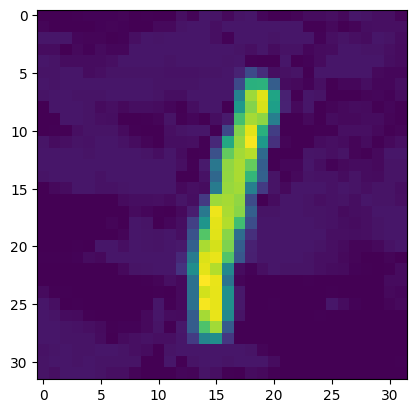

In [545]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [546]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]


In [547]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [548]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [549]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.5017274223001988
distancia energia distribucion base y el ejemplo natural  0.5981803252357688


In [550]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [551]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.1997909565410816
distancia energia distribucion base y el ejemplo adversario  0.7774986239695407


In [552]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-553-b23951ae16f6>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-553-b23951ae16f6>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

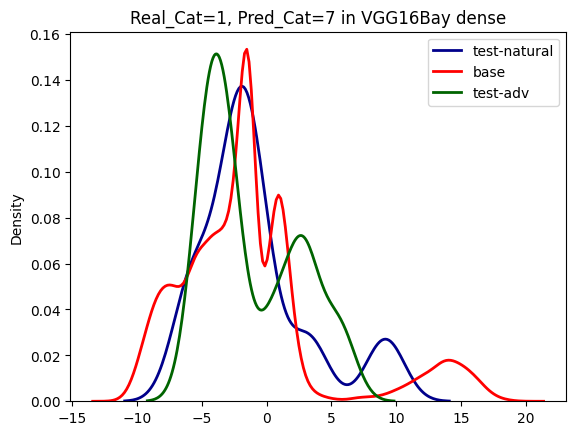

In [553]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'B1GUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [554]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [555]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [556]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [557]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [558]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  1


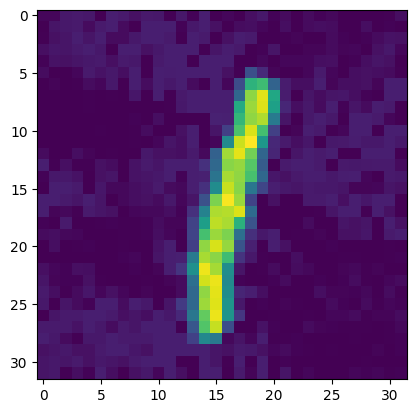

In [559]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [560]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]


In [561]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [562]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

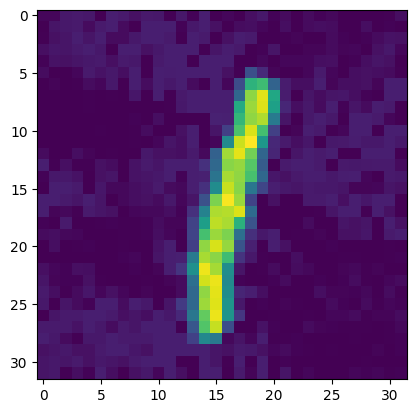

In [563]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [564]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.7159274231329258
distancia energia distribucion base y el ejemplo natural  0.7789979219510824


In [565]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [566]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.5181679817301843
distancia energia distribucion base y el ejemplo adversario  1.0259569725334774


In [567]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-568-08a31cdca667>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-568-08a31cdca667>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

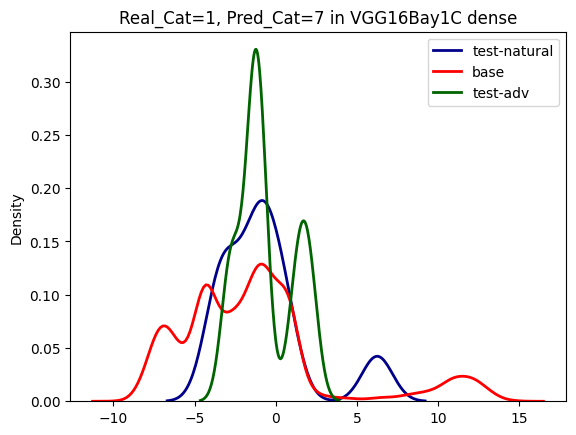

In [568]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'1CGUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 8

In [569]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 8

In [570]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [571]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [572]:
vgg_full_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 4s 284ms/step - loss: 62327184412947513344.0000 - accuracy: 0.9880


[6.232718441294751e+19, 0.9879807829856873]

In [573]:
vgg_1c_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 2s 111ms/step - loss: 2160857282806546432.0000 - accuracy: 0.9916


[2.1608572828065464e+18, 0.9915865659713745]

### 100 Bayesiano

In [574]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [575]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [576]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [577]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [578]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [579]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

el label verdadero es:  1


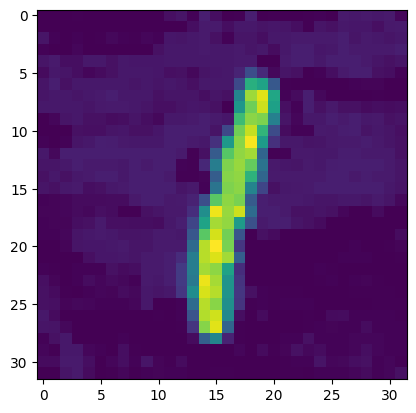

In [580]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [581]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [582]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [583]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [584]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.9916662340463601
distancia energia distribucion base y el ejemplo natural  0.6368092879526296


In [585]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [586]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.687276584376586
distancia energia distribucion base y el ejemplo adversario  1.1753502269980192


In [587]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-588-b23951ae16f6>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-588-b23951ae16f6>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

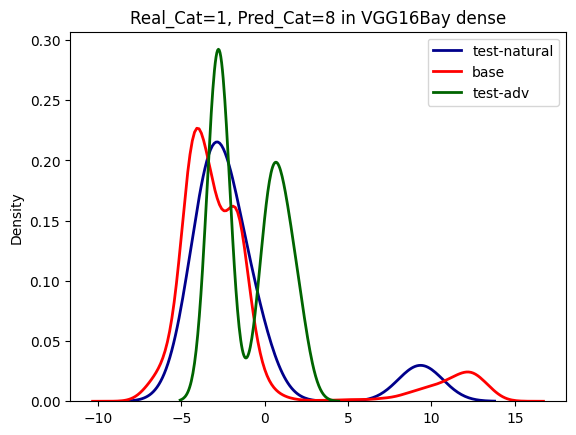

In [588]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'B1GUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [589]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [590]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [591]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [592]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [593]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  1


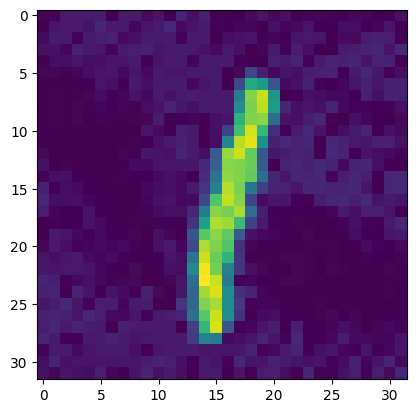

In [594]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [595]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [596]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [597]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

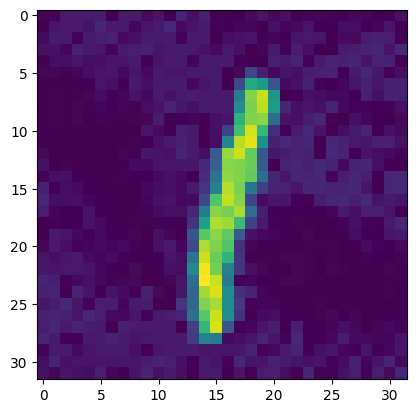

In [598]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [599]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.8014013374221569
distancia energia distribucion base y el ejemplo natural  0.46676116816578184


In [600]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [601]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.188900506215581
distancia energia distribucion base y el ejemplo adversario  1.4548872978953984


In [602]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-603-08a31cdca667>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-603-08a31cdca667>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

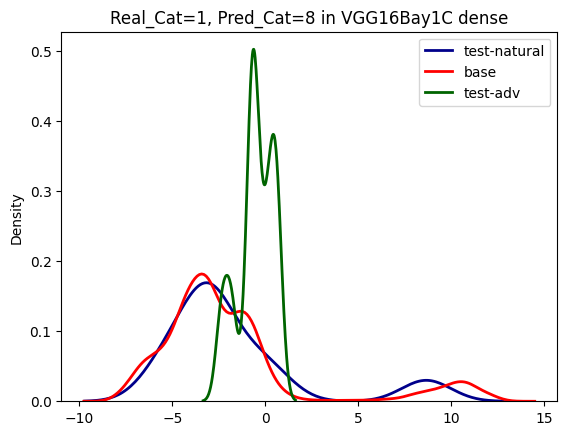

In [603]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'1CGUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 9

In [604]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 9

In [605]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [606]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [607]:
vgg_full_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 5s 292ms/step - loss: 878083798556737536.0000 - accuracy: 0.9699


[8.780837985567375e+17, 0.9698660969734192]

In [608]:
vgg_1c_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 2s 106ms/step - loss: 3927841188119314432.0000 - accuracy: 0.9810


[3.9278411881193144e+18, 0.9810267686843872]

### 100 Bayesiano

In [609]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [610]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['mnf_'+Cap](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [611]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [612]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [613]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [614]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

el label verdadero es:  1


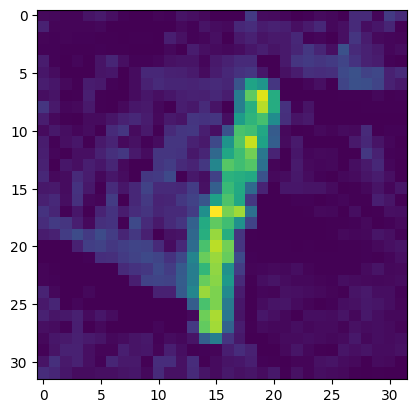

In [615]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [616]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]


In [617]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['mnf_'+Cap](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [618]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [619]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.2411212035774633
distancia energia distribucion base y el ejemplo natural  0.5799030014034039


In [620]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [621]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.4305964749569435
distancia energia distribucion base y el ejemplo adversario  1.321338349913332


In [622]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-623-b23951ae16f6>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-623-b23951ae16f6>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

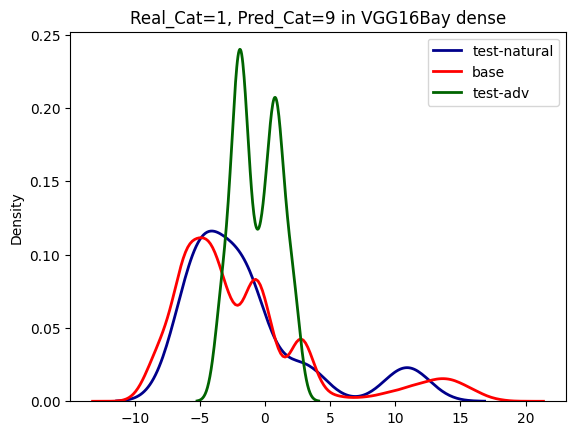

In [623]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1GUM',Cap,Att,Epx,DS,Cat,Vic,'B1GUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [624]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [625]:
value1c_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['mnf_'+Cap+'_1'](databx)
        value1c_list.append(predictbx)
value1c_list= np.concatenate(value1c_list)

In [626]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list)

In [627]:
value1c_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](dataxtest1)
        value1c_list_test.append(predictx)
value1c_list_test= np.concatenate(value1c_list_test)

In [628]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_test)

el label verdadero es:  1


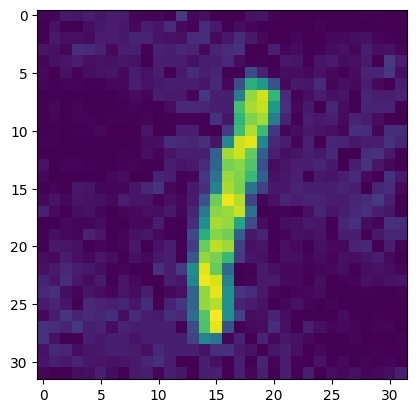

In [629]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [630]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]


In [631]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['mnf_'+Cap+'_1'](img_adv[None,...])
        value1c_list_testadv.append(predictx)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [632]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

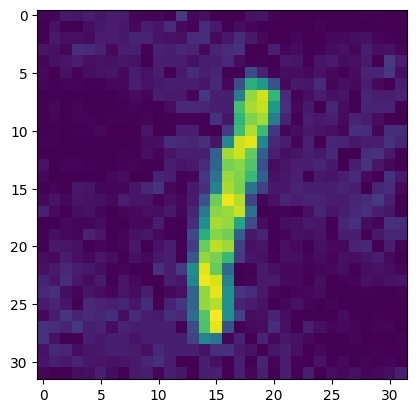

In [633]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [634]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.238223307139198
distancia energia distribucion base y el ejemplo natural  0.5903151971420176


In [635]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [636]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.8886490343388984
distancia energia distribucion base y el ejemplo adversario  1.4224839865491405


In [637]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-638-08a31cdca667>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-638-08a31cdca667>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

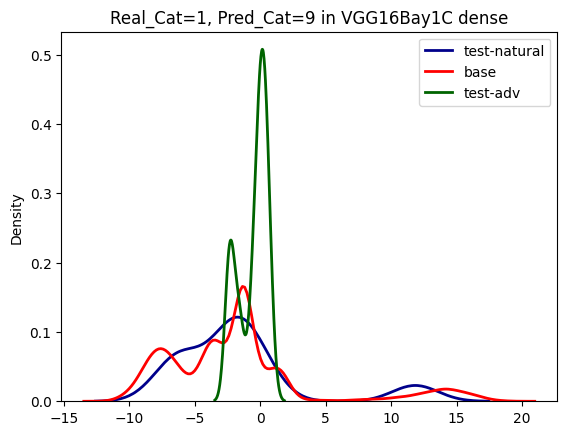

In [638]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CGUM',Cap,Att,Epx,DS,Cat,Vic,'1CGUM')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)